In [47]:
# First cell - Check requirements and setup
import sys
import pkg_resources
import subprocess

def check_and_install_requirements(requirements_file):
    try:
        # Read requirements
        with open(requirements_file) as f:
            requirements = [line.strip() for line in f if line.strip() and not line.startswith('#')]
        
        # Check installed packages
        installed = {pkg.key: pkg.version for pkg in pkg_resources.working_set}
        missing = []
        
        for requirement in requirements:
            name = requirement.split('==')[0]
            if name.lower() not in installed:
                missing.append(requirement)
        
        # Install missing packages
        if missing:
            print(f"Missing packages: {missing}")
            subprocess.check_call([sys.executable, "-m", "pip", "install"] + missing)
            print("Packages installed successfully!")
        else:
            print("All required packages are installed!")
            
    except Exception as e:
        print(f"Error checking/installing requirements: {str(e)}")

In [48]:
check_and_install_requirements('requirements.txt')

Missing packages: ['rdkit==2024.3.6', 'lightgbm==4.5.0', 'tqdm>=4.65.0']
Packages installed successfully!


In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem  # Added Descriptors import


In [50]:
# Set display options
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)

In [51]:
#Load data from data/raw/train
# First column is ind
df = pd.read_csv('../data/raw/training_smiles.csv', index_col=0)


In [52]:
df.head()

,SMILES,ACTIVE
INDEX,,
1,CCOc1cc(CNc2cccc3ccccc23)cc(Br)c1OCC(=O)NC(C)(C)C,0.0
2,COc1cc(-c2ccc(Nc3ccccc3C(=O)O)c(OC)c2)ccc1Nc1ccccc1C(=O)O,0.0
3,O=c1cc(O)n(-c2ccc(Cl)cc2)c(=S)[nH]1,0.0
4,COc1ccc(NC(=O)C/C(C)=N/NC(=O)CCc2ccccc2)c(OC)c1,0.0
5,CC(=O)/C=C(\C)NCCNc1c(F)c(F)c(CO)c(F)c1F,0.0


In [53]:
# Basic dataset info
print(f'Dataset Shape: {df.shape}')
duplicate_count = df.duplicated().sum()
print(f'Duplicate Rows: {duplicate_count}')

Dataset Shape: (208938, 2)
Duplicate Rows: 226


In [54]:
print("\nBasic Statistics:")
print(df.describe())


Basic Statistics:
              ACTIVE
count  208938.000000
mean        0.037968
std         0.191120
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000


In [55]:
# Analyze SMILES strings
print("\nSMILES Analysis:")
print(df.describe(include=['object']))


SMILES Analysis:
                                SMILES
count                           208938
unique                          208708
top     COc1c2c(cc3c1OCO3)CC[N+](C)=C2
freq                                 3


In [56]:
# Check class distribution
print("\nClass Distribution:")
print(df['ACTIVE'].value_counts())


Class Distribution:
ACTIVE
0.0    201005
1.0      7933
Name: count, dtype: int64


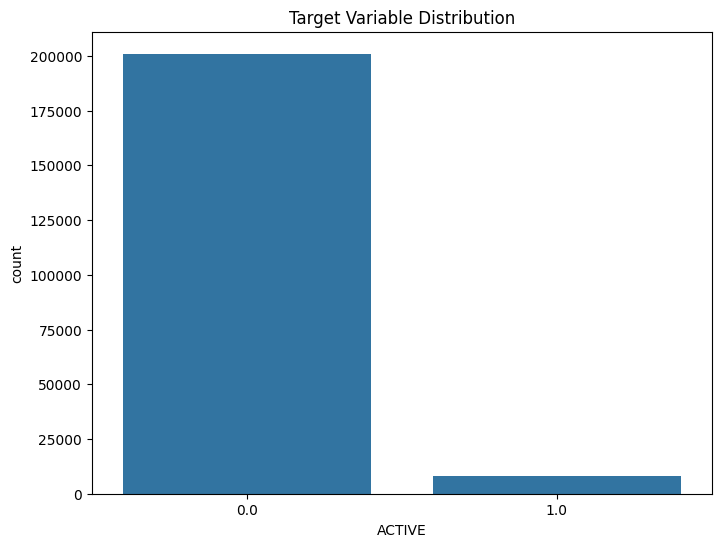

In [57]:
# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='ACTIVE', data=df)
plt.title('Target Variable Distribution')
plt.show()

In [58]:
# Generate some basic molecular descriptors for analysis
print("\nGenerating molecular descriptors...")
mols = [Chem.MolFromSmiles(smiles) for smiles in df['SMILES']]
valid_mols = [m for m in mols if m is not None]



Generating molecular descriptors...


[18:07:42] WARNING: not removing hydrogen atom without neighbors


In [59]:
# Calculate basic properties
mol_weights = [Descriptors.ExactMolWt(mol) for mol in valid_mols]
num_atoms = [mol.GetNumAtoms() for mol in valid_mols]
num_bonds = [mol.GetNumBonds() for mol in valid_mols]

In [60]:
# Add to dataframe for analysis
df_mol = pd.DataFrame({
    'MolWeight': mol_weights,
    'NumAtoms': num_atoms,
    'NumBonds': num_bonds
})

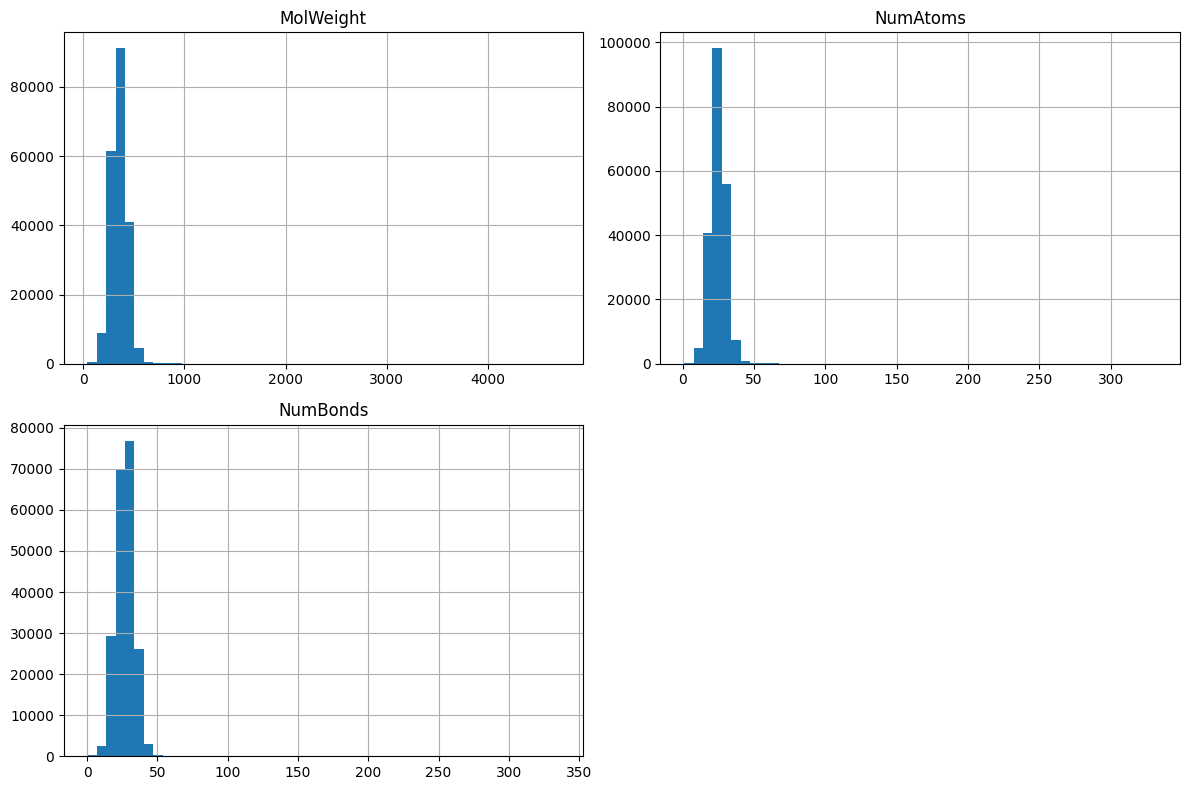

In [61]:
# Visualize distributions
df_mol.hist(bins=50, figsize=(12, 8))
plt.tight_layout()
plt.show()

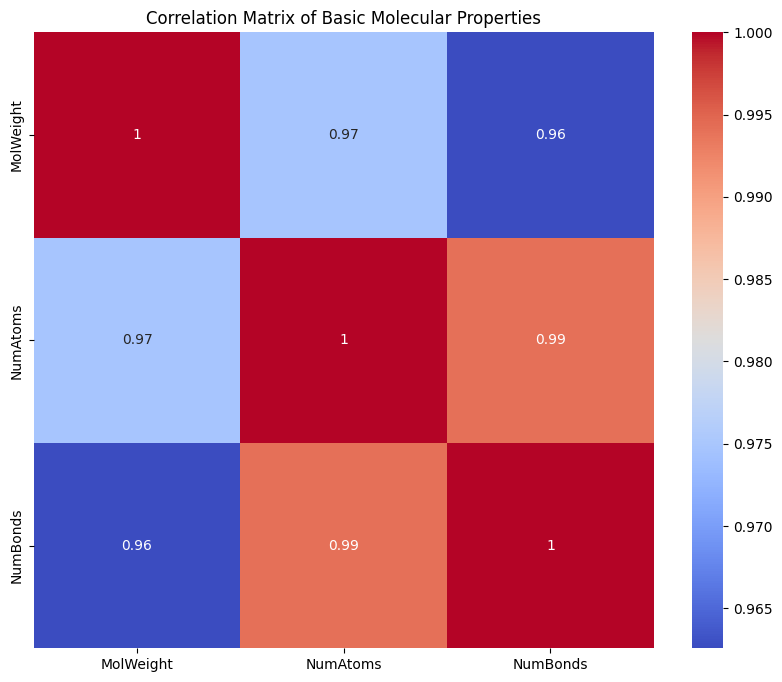

In [62]:
# Correlation analysis
plt.figure(figsize=(10, 8))
sns.heatmap(df_mol.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Basic Molecular Properties')
plt.show()

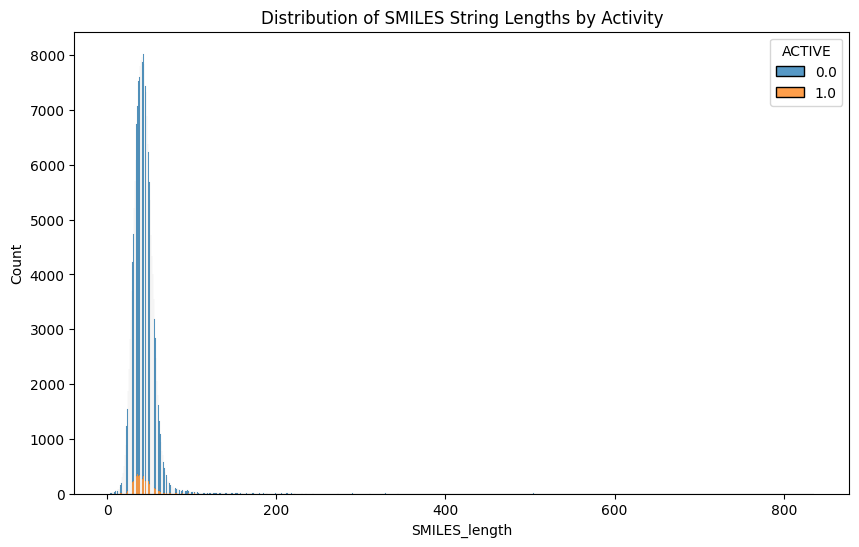

In [63]:
# SMILES Length Analysis
df['SMILES_length'] = df['SMILES'].str.len()
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='SMILES_length', hue='ACTIVE', multiple="stack")
plt.title('Distribution of SMILES String Lengths by Activity')
plt.show()

In [64]:
# Chemical Element Analysis
from collections import Counter

def get_elements(smiles):
    # Extract uppercase letters followed by optional lowercase
    import re
    elements = re.findall(r'[A-Z][a-z]?', ''.join(filter(str.isalpha, smiles)))
    return Counter(elements)


<Figure size 1200x600 with 0 Axes>

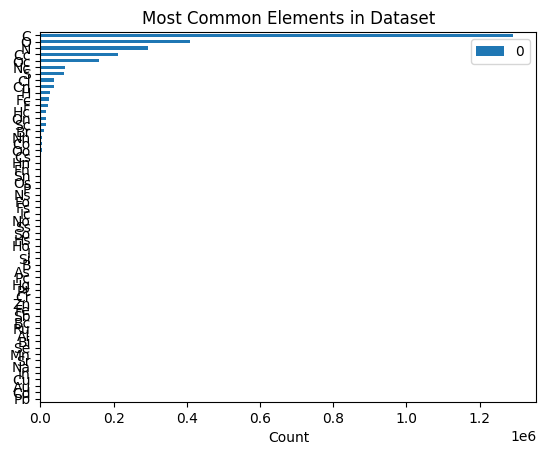

In [65]:
# Get most common elements
all_elements = Counter()
for smiles in df['SMILES']:
    all_elements.update(get_elements(smiles))

plt.figure(figsize=(12, 6))
elements_df = pd.DataFrame.from_dict(all_elements, orient='index')
elements_df.sort_values(by=0, ascending=True).plot(kind='barh')
plt.title('Most Common Elements in Dataset')
plt.xlabel('Count')
plt.show()

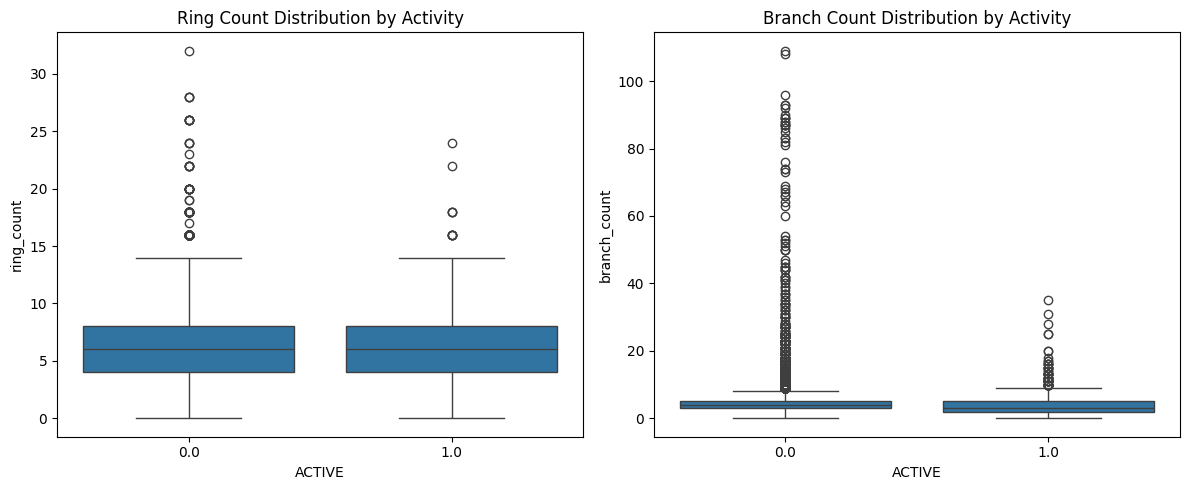

In [66]:
# Structural Features Analysis
def count_rings(smiles):
    return sum(c.isdigit() for c in smiles)

df['ring_count'] = df['SMILES'].apply(count_rings)
df['branch_count'] = df['SMILES'].str.count('\(')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='ACTIVE', y='ring_count', data=df)
plt.title('Ring Count Distribution by Activity')

plt.subplot(1, 2, 2)
sns.boxplot(x='ACTIVE', y='branch_count', data=df)
plt.title('Branch Count Distribution by Activity')
plt.tight_layout()
plt.show()

In [67]:
# Check for Invalid/Problematic SMILES
invalid_smiles = []
for idx, smiles in enumerate(df['SMILES']):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        invalid_smiles.append(idx)

print(f"\nNumber of Invalid SMILES: {len(invalid_smiles)}")
if invalid_smiles:
    print("Examples of Invalid SMILES:")
    print(df.loc[invalid_smiles[:5], 'SMILES'])


[18:09:35] WARNING: not removing hydrogen atom without neighbors



Number of Invalid SMILES: 0


/var/folders/_3/7nx89wtj68x77c5zlhz5fztm0000gn/T/ipykernel_13383/2415281389.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  activity_rates = df_temp.groupby('bin')['ACTIVE'].mean()


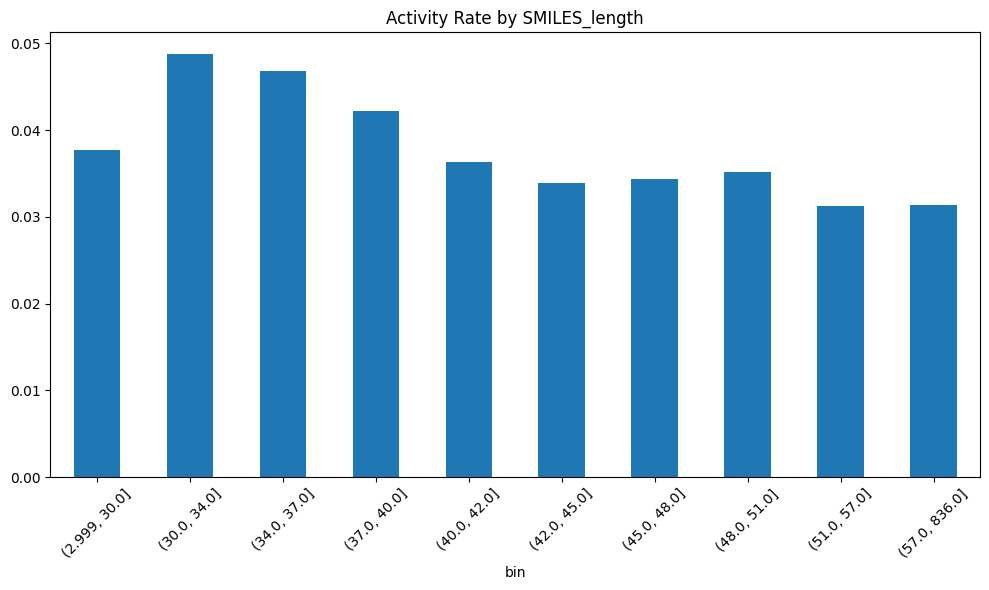

/var/folders/_3/7nx89wtj68x77c5zlhz5fztm0000gn/T/ipykernel_13383/2415281389.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  activity_rates = df_temp.groupby('bin')['ACTIVE'].mean()


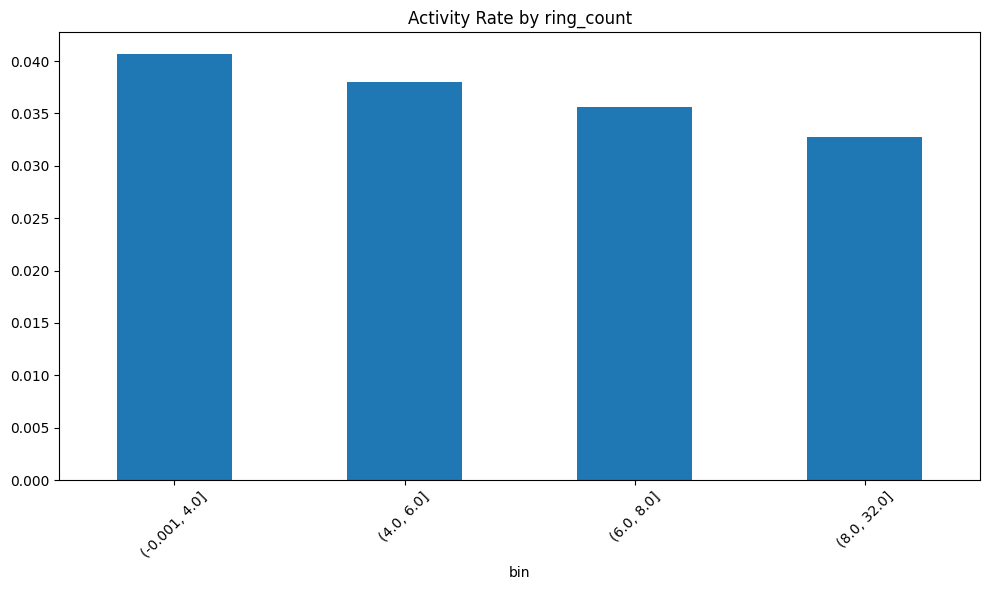

/var/folders/_3/7nx89wtj68x77c5zlhz5fztm0000gn/T/ipykernel_13383/2415281389.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  activity_rates = df_temp.groupby('bin')['ACTIVE'].mean()


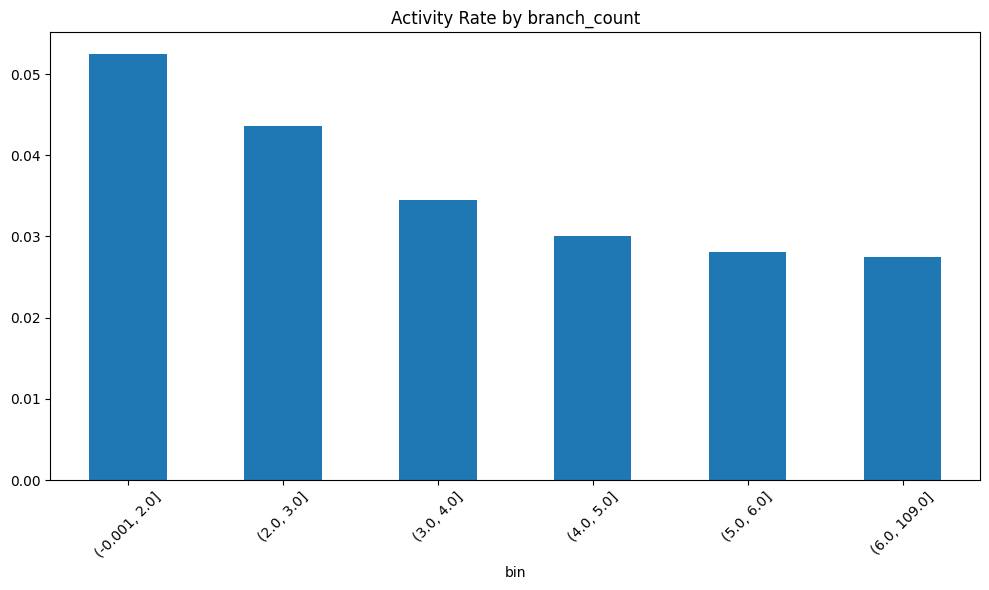

In [68]:
# Activity Rate by Structural Features
def analyze_activity_rate(df, feature, bins=10):
    df_temp = pd.DataFrame({
        feature: df[feature],
        'ACTIVE': df['ACTIVE']
    })
    df_temp['bin'] = pd.qcut(df_temp[feature], bins, duplicates='drop')
    activity_rates = df_temp.groupby('bin')['ACTIVE'].mean()
    
    plt.figure(figsize=(10, 6))
    activity_rates.plot(kind='bar')
    plt.title(f'Activity Rate by {feature}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

analyze_activity_rate(df, 'SMILES_length')
analyze_activity_rate(df, 'ring_count')
analyze_activity_rate(df, 'branch_count')

In [69]:
missing_values = df.isnull().sum()
print(missing_values)

SMILES           0
ACTIVE           0
SMILES_length    0
ring_count       0
branch_count     0
dtype: int64
